<a href="https://colab.research.google.com/github/AOlivr/SER-347_Scripts/blob/main/Versao2_firescar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NDVI PRÉ FOGO - CBERS4A - Parque Nacional do Veadeiros

In [1]:
# Importação dos das bibliotecas e módulos
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import numpy as np
gdal.UseExceptions()

In [2]:
# Ao escrever o link de acesso do arquivo, importante colocar 'r' antes da string para reconhecimento correto do caminho
redprefogo = gdal.Open(r'/content/prefogo_parnaveadeiros_CBERS_4A_WPM_20210816_207_131_L4_BAND3.tif', gdal.GA_ReadOnly)
nirprefogo = gdal.Open(r'/content/prefogo_parnaveadeiros_CBERS_4A_WPM_20210816_207_131_L4_BAND4.tif', gdal.GA_ReadOnly)

In [3]:
# Criação de uma matriz NumPy. Permite o uso de todas as operações da NumPy.
matriz_redprefogo = redprefogo.ReadAsArray()
matriz_nirprefogo = nirprefogo.ReadAsArray()

In [4]:
# Transformação do tipo de dado de Int16 para Float. Importante para realizar o cálculo do NDVI.
matriz_redprefogo = matriz_redprefogo.astype(float)
matriz_nirprefogo = matriz_nirprefogo.astype(float)

# Cálculo do NDVI PRÉ FOGO
ndvi_prefogo = (matriz_nirprefogo - matriz_redprefogo) / (matriz_redprefogo + matriz_nirprefogo + 0.000000001)

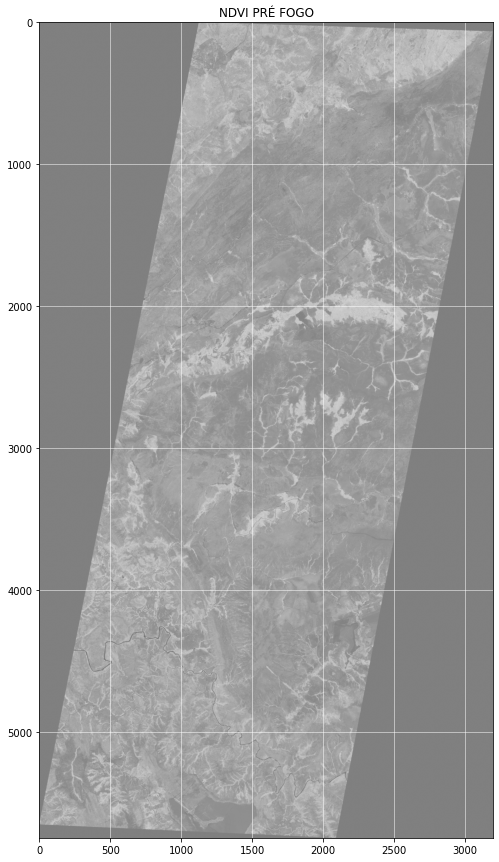

In [5]:
plt.figure(figsize=(30, 15))
plt.title('NDVI PRÉ FOGO')
plt.imshow(ndvi_prefogo, cmap='gray', vmin=-1.0, vmax=1.0)
plt.grid(color='w', linestyle='-', linewidth=0.5)

NDVI PÓS FOGO - CBERS4A - Parque Nacional do Veadeiros

In [6]:
# Ao escrever o link de acesso do arquivo, importante colocar 'r' antes da string para reconhecimento correto do caminho
redposfogo = gdal.Open(r'/content/posfogo_parnaveadeiros_CBERS_4A_WPM_20210921_206_131_L2_BAND3.tif', gdal.GA_ReadOnly)
nirposfogo = gdal.Open(r'/content/posfogo_parnaveadeiros_CBERS_4A_WPM_20210921_206_131_L2_BAND4.tif', gdal.GA_ReadOnly)

In [7]:
# Criação de uma matriz NumPy. Permite o uso de todas as operações da NumPy.
matriz_redposfogo = redposfogo.ReadAsArray()
matriz_nirposfogo = nirposfogo.ReadAsArray()

In [8]:
# Transformação do tipo de dado de Int16 para Float. Importante para realizar o cálculo do NDVI.
matriz_redposfogo = matriz_redposfogo.astype(float)
matriz_nirposfogo = matriz_nirposfogo.astype(float)

# Cálculo do NDVI PÓS FOGO
ndvi_posfogo = (matriz_nirposfogo - matriz_redposfogo) / (matriz_nirposfogo + matriz_redposfogo + 0.000000001)

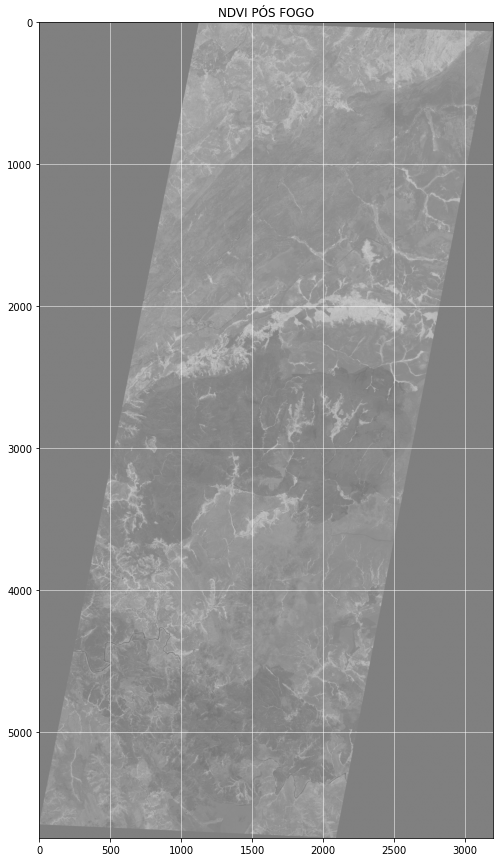

In [9]:
plt.figure(figsize=(30,15))
plt.title("NDVI PÓS FOGO")
plt.imshow(ndvi_posfogo, cmap='gray', vmin=-1.0, vmax=1.0)
plt.grid(color='w', linestyle='-', linewidth=0.5)

In [10]:
ndvi_diferenca = ndvi_prefogo - ndvi_posfogo

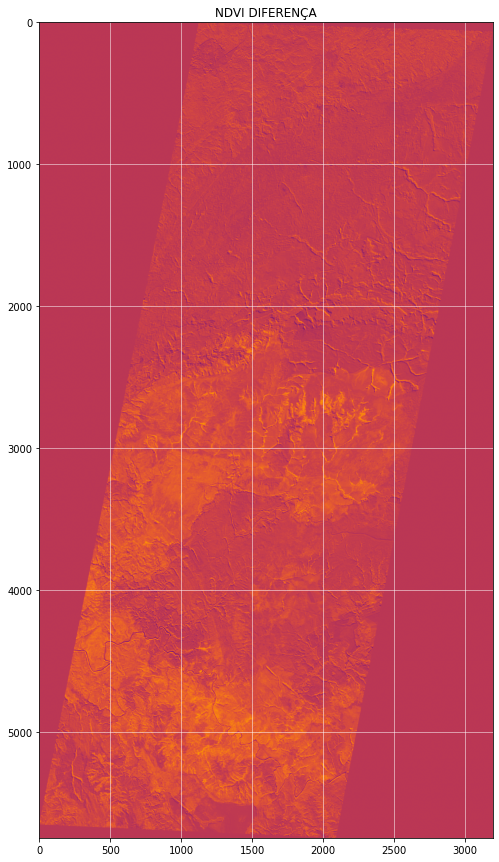

In [11]:
# Quanto mais branca a região, maior a modificação na estrutura da vegetação entre o período anterior e o posterior ao fogo.
plt.figure(figsize=(30,15))
plt.title("NDVI DIFERENÇA")
plt.imshow(ndvi_diferenca, cmap='inferno', vmin=-1.0, vmax=1.0)
plt.grid(color='w', linestyle='-', linewidth=0.5)

Crescimento de região e retorno da área em km² e hectares

In [12]:
# Cria, a partir da matriz da diferença de ndvi, uma matriz binária, onde 1 = não cicatriz; e 2 = cicatriz potencial
copy = np.zeros(shape=(ndvi_diferenca.shape), dtype=np.uint8)  
copy = np.where(ndvi_diferenca < 0.15, 1, np.where(ndvi_diferenca >= 0.15, 0, 0))

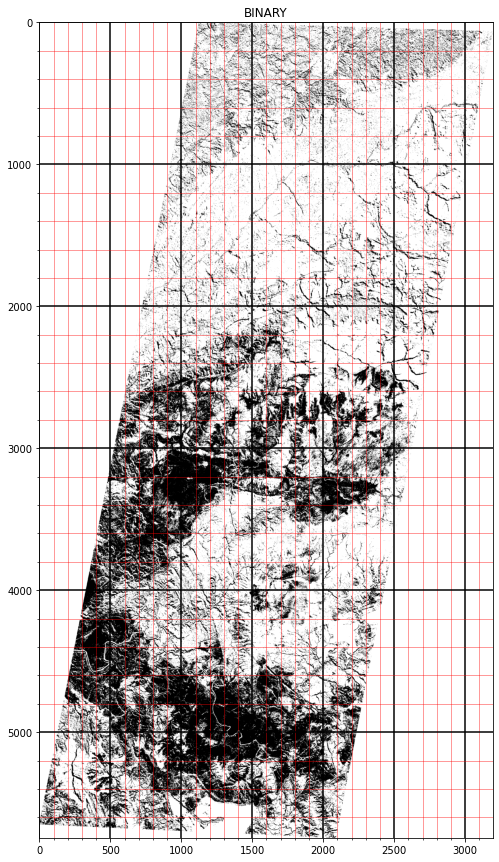

In [13]:
# Plota a matriz binária
plt.figure(figsize=(30,15))
plt.title('BINARY')
plt.imshow(copy, cmap='gray')
plt.grid(b=True, which='major', color='black', linestyle='-', linewidth = 1.5)
plt.grid(b=True, which='minor', color='red', linestyle='-', alpha=1.5)
plt.minorticks_on()
plt.show()

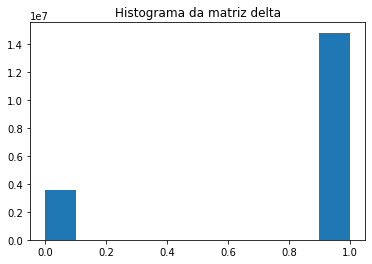

In [14]:
# Exibe o histograma da matriz binária
plt.hist(copy.flatten(), bins=10, range=(0,1)) 
plt.title('Histograma da matriz delta');

In [24]:
# Input das coordenadas em linha e coluna
coords = []
xline = int(input('Line: '))
ycolumn = int(input('Column: '))
coords.append (xline-1)
coords.append (ycolumn-1)

Line: 3200
Column: 1000


In [25]:
# Seleciona os arredores do pixel informado
num_neighbor = 1

while (num_neighbor < 1000):
  left = max(0,coords[0]-num_neighbor)
  right = max(0,coords[0]+num_neighbor+1)
  bottom = max(0,coords[1]-num_neighbor)
  top = max(0,coords[1]+num_neighbor+1)
  matriz_run = copy[left:right,bottom:top]  

  if (matriz_run == 1).all():
    print ('O valor central deve ser 0')
    break

  else:
    for item in matriz_run:
      if (item == 0).any():
        num_neighbor = num_neighbor + 100

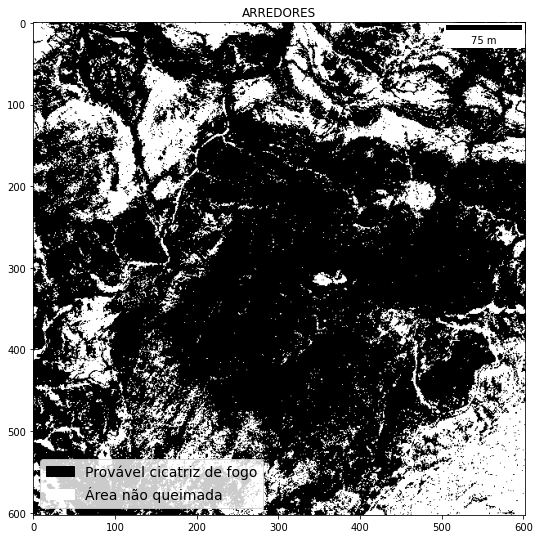

In [26]:
# Plota, com base na matriz binária, uma nova matriz criada a partir da coordenada informada anteriormente
plt.figure(figsize=(30, 30))
plt.subplot(133)
plt.title('ARREDORES')
scalebar = ScaleBar(0.8) # 1 pixel = 8 metros
plt.gca().add_artist(scalebar)
plt.imshow(matriz_run, cmap='gray')
black_patch = mpatches.Patch(color='black', label='Provável cicatriz de fogo')
white_patch = mpatches.Patch(color='white', label='Área não queimada')
plt.legend(handles=[black_patch, white_patch], loc='lower left', prop={'size': 14});

In [22]:
# Para os arredores do pixel informado anteriormente, realiza-se o cálculo da área estimada das cicatrizes de fogo
area = []

for item in matriz_run:
  for i in item:
    while (i == 0):
      i = (8**2)
      area.append(i)
  break

area_km = (sum(area) / 1000)
area_ha = (area_km * 100)
print ('Área estimada das cicatrizes de fogo: ',area_km,'km²')
print ('                                      ',area_ha,'ha')

Área estimada das cicatrizes de fogo:  28.48 km²
                                       2848.0 ha


In [19]:
plt.imsave('Fire_Scar.tiff', matriz_run)